# Dealing with Partial Observability In Reinforcement Learning
> "Using RLlib, frame stacking, and self-attention to master environments with partial observations."

- hide: true
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, gym, ray, rllib, tensorflow, machine learning, reinforcement learning, sequence, attention]
- image: images/cartpole.jpg

> Important: This blog post is still work in progress.

In reinforcement learning (RL), the RL agent typically selects a suitable action based on the last observation.
In many practical environments, the full state can only be observed partially,
such that important information may be missing when just considering the last observation.
This blog post covers options for dealing with missing and only partially observed state,
e.g., considering a *sequence* of last observations and applying *self-attention* to this sequence.

> Note: This blog post is based on and very related to [Anyscale's blog post on attention nets with RLlib](https://www.anyscale.com/blog/attention-nets-and-more-with-rllibs-trajectory-view-api). In comparison, I focus less on RLlib's trajectory API and more on providing a practical, end-to-end tutorial.


## Example: The CartPole Gym Environment

As an example, consider the popular [OpenAI Gym CartPole environment](https://gym.openai.com/envs/CartPole-v1/).
Here, the task is to move a cart left or right in order to balance a pole on the cart as long as possible.

![OpenAI Gym CartPole-v1 Environment](attention/cartpole.gif "OpenAI Gym CartPole-v1 Environment")

In the normal [`CartPole-v1` environment](https://gym.openai.com/envs/CartPole-v1/), the RL agent observes four scalar values ([defined here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L26:L32)):
* The cart position, i.e., where the cart currently is.
* The cart velocity, i.e., how fast the cart is currently moving and in which direction (can be positive or negative).
* The pole angle, i.e., how tilted the pole currently is and in which direction.
* The pole angular velocity, i.e., how fast the pole is currently moving and in which direction.

All four observations are important to decide whether the cart should move left or right.

Now, assume the RL agent only has access to an instant snapshot of the cart and the pole (e.g., through a photo/raw pixels)
and can neither observe cart velocity nor pole angular velocity.
In this case, the RL agent only has partial observations and does not know whether and how fast the pole is currently swinging.
As a result, standard RL agents cannot solve the problem and do not learn to balance the pole.
How to deal with this problem of partial observations, i.e., missing state (here, cart and pole velocity)?


## Options for Dealing With Partial Observations

There are different options for dealing with partial observations/missing state, e.g., missing velocity in the CartPole example:

1. Add the missing state explicitly, e.g., measure and observe velocity. Note that this may require installing extra sensors or may even be infeasible in some scenarios.
2. Ignore the missing state, i.e., just rely on the available, partial observations. Depending on the missing state, this may be problematic and keep the agent from learning.
3. Keep track of a sequence of the last observations. By observing the cart position and pole angle over time, the agent can implicitly derive their velocity. There are different ways to deal with this sequence:
   1. Just use the sequence as is for a standard multi-layer perceptron (MLP)/dense feedforward neural network.
   2. Feed the sequence into a recurrent neural network (RNN), e.g., with long short-term memory (LSTM).
   3. Feed the sequence into a neural network with *self-attention*.

In the following, I go through each option in more detail and illustrate them using simple example code.


### Setup

For the examples, I use a PPO RL agent from Ray RLlib with the CartPole environment, described above.

To install these dependencies, run the following code (tested with Python 3.8 on Windows):

In [32]:
#collapse-output
!pip install ray[rllib]==1.8.0
!pip install tensorflow==2.7.0
!pip install seaborn==0.11.2
!pip install gym==0.21.0
!pip install pyglet==1.5.21

Start up ray, load the default PPO config, and determine the number of training iterations,
which is the same for all options (for comparability).

In [3]:
import ray
from ray.rllib.agents import ppo

# adjust num_cpus and num_gpus to your system
# for some reason, num_cpus=2 gets stuck on my system (when trying to train)
ray.init(num_cpus=3, ignore_reinit_error=True)

# stop conditions based on training iterations (each with 4000 train steps)
stop = {"training_iteration": 10}

2021-11-29 17:43:44,346	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


### Option 1: Explicitly Add Missing State

Sometimes, it is possible to extend the observations and explicitly add important state that was previously unobserved.
In the CartPole example, the cart and pole velocity can simply be "added" by using the default `CartPole-v1` environment.
Here, the cart velocity and pole velocity are already included in the observations.

Note that in many practical scenarios such "missing" state cannot be added and observed simply.
Instead, it may require installing additional sensors or may even be completely infeasible.

Let's start with the best case, i.e., explicitly including the missing state.

In [34]:
import gym

# the default CartPole env has all 4 observations: position and velocity of both cart and pole
env = gym.make("CartPole-v1")
env.observation_space.shape

(4,)

In [35]:
#collapse-output

# run PPO on the default CartPole-v1 env
config1 = ppo.DEFAULT_CONFIG.copy()
config1["env"] = "CartPole-v1"

# training takes a while
results1 = ray.tune.run("PPO", config=config1, stop=stop)
print("Option 1: Training finished successfully")

Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,PENDING,


(pid=9332) 2021-11-23 19:47:10,868	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=9332) 2021-11-23 19:47:10,868	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=9332) 2021-11-23 19:47:10,868	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=6508) 2021-11-23 19:47:22,968	WARNING deprecation.py:38 -- Deprecatio

Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332


(pid=9332) 2021-11-23 19:47:25,401	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=9332) 2021-11-23 19:47:25,401	INFO trainable.py:110 -- Trainable.setup took 14.534 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=9332) 2021-11-23 19:47:25,401	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332


(pid=9332) 2021-11-23 19:47:29,301	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-23_19-47-32
  done: false
  episode_len_mean: 23.201183431952664
  episode_media: {}
  episode_reward_max: 64.0
  episode_reward_mean: 23.201183431952664
  episode_reward_min: 8.0
  episodes_this_iter: 169
  episodes_total: 169
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6663767099380493
          entropy_coeff: 0.0
          kl: 0.02739105187356472
          model: {}
          policy_loss: -0.04134032875299454
          total_loss: 200.2156219482422
          vf_explained_var: 0.026224354282021523
          vf_loss: 200.25149536132812
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,1,7.51691,4000,23.2012,64,8,23.2012


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-23_19-47-39
  done: false
  episode_len_mean: 42.95
  episode_media: {}
  episode_reward_max: 150.0
  episode_reward_mean: 42.95
  episode_reward_min: 10.0
  episodes_this_iter: 87
  episodes_total: 256
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.6131702065467834
          entropy_coeff: 0.0
          kl: 0.015614509582519531
          model: {}
          policy_loss: -0.030681779608130455
          total_loss: 312.3175964355469
          vf_explained_var: 0.07965515553951263
          vf_loss: 312.3436279296875
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
    num_steps_trained_thi

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,2,14.3835,8000,42.95,150,10,42.95


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-23_19-47-46
  done: false
  episode_len_mean: 72.01
  episode_media: {}
  episode_reward_max: 367.0
  episode_reward_mean: 72.01
  episode_reward_min: 10.0
  episodes_this_iter: 31
  episodes_total: 287
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5750772953033447
          entropy_coeff: 0.0
          kl: 0.010552152059972286
          model: {}
          policy_loss: -0.02355009876191616
          total_loss: 682.247802734375
          vf_explained_var: 0.08913025259971619
          vf_loss: 682.2681274414062
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_steps_trained_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,3,20.9668,12000,72.01,367,10,72.01


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-23_19-47-53
  done: false
  episode_len_mean: 99.53
  episode_media: {}
  episode_reward_max: 367.0
  episode_reward_mean: 99.53
  episode_reward_min: 10.0
  episodes_this_iter: 24
  episodes_total: 311
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5543258190155029
          entropy_coeff: 0.0
          kl: 0.005451680161058903
          model: {}
          policy_loss: -0.013567883521318436
          total_loss: 657.56103515625
          vf_explained_var: 0.31792160868644714
          vf_loss: 657.572998046875
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num_steps_trained_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,4,27.6669,16000,99.53,367,10,99.53


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,4,27.6669,16000,99.53,367,10,99.53


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-23_19-47-59
  done: false
  episode_len_mean: 131.85
  episode_media: {}
  episode_reward_max: 472.0
  episode_reward_mean: 131.85
  episode_reward_min: 11.0
  episodes_this_iter: 16
  episodes_total: 327
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5512375831604004
          entropy_coeff: 0.0
          kl: 0.0024686120450496674
          model: {}
          policy_loss: -0.010818097740411758
          total_loss: 538.4854125976562
          vf_explained_var: 0.321399986743927
          vf_loss: 538.4955444335938
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    num_steps_train

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,5,34.2836,20000,131.85,472,11,131.85


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-11-23_19-48-06
  done: false
  episode_len_mean: 165.3
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 165.3
  episode_reward_min: 14.0
  episodes_this_iter: 14
  episodes_total: 341
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 4.999999873689376e-05
          entropy: 0.5289359092712402
          entropy_coeff: 0.0
          kl: 0.007540307007730007
          model: {}
          policy_loss: -0.010302959010004997
          total_loss: 430.6041564941406
          vf_explained_var: 0.3625507056713104
          vf_loss: 430.6133117675781
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
    num_steps_trained

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,6,40.8671,24000,165.3,500,14,165.3


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-11-23_19-48-13
  done: false
  episode_len_mean: 200.73
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 200.73
  episode_reward_min: 14.0
  episodes_this_iter: 10
  episodes_total: 351
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.15000000596046448
          cur_lr: 4.999999873689376e-05
          entropy: 0.5529451966285706
          entropy_coeff: 0.0
          kl: 0.004082479979842901
          model: {}
          policy_loss: -0.007522972766309977
          total_loss: 385.4500427246094
          vf_explained_var: 0.34760990738868713
          vf_loss: 385.45697021484375
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num_steps_tra

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,7,47.6834,28000,200.73,500,14,200.73


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-11-23_19-48-20
  done: false
  episode_len_mean: 231.96
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 231.96
  episode_reward_min: 22.0
  episodes_this_iter: 8
  episodes_total: 359
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.07500000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5215219259262085
          entropy_coeff: 0.0
          kl: 0.003867241321131587
          model: {}
          policy_loss: -0.006445886567234993
          total_loss: 463.6306457519531
          vf_explained_var: 0.039233140647411346
          vf_loss: 463.6368408203125
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
    num_steps_trai

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,8,54.4999,32000,231.96,500,22,231.96


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-11-23_19-48-26
  done: false
  episode_len_mean: 262.68
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 262.68
  episode_reward_min: 23.0
  episodes_this_iter: 9
  episodes_total: 368
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.03750000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5338630676269531
          entropy_coeff: 0.0
          kl: 0.007856571115553379
          model: {}
          policy_loss: -0.023872433230280876
          total_loss: 322.21954345703125
          vf_explained_var: 0.245315819978714
          vf_loss: 322.2431335449219
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
    num_steps_traine

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,RUNNING,127.0.0.1:9332,9,61.2168,36000,262.68,500,23,262.68


Result for PPO_CartPole-v1_bd6e2_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-11-23_19-48-33
  done: true
  episode_len_mean: 293.67
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 293.67
  episode_reward_min: 23.0
  episodes_this_iter: 8
  episodes_total: 376
  experiment_id: ada6434c43d44cc4854441944ca25a66
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.03750000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5301569700241089
          entropy_coeff: 0.0
          kl: 0.003627386409789324
          model: {}
          policy_loss: -0.014947282150387764
          total_loss: 501.4374694824219
          vf_explained_var: -0.0290857944637537
          vf_loss: 501.4522705078125
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
    num_steps_traine

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_bd6e2_00000,TERMINATED,127.0.0.1:9332,10,67.8499,40000,293.67,500,23,293.67


(pid=9332) [2021-11-23 19:48:34,182 E 9332 1660] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=9332) Windows fatal exception: access violation
(pid=9332) 
(pid=5972) [2021-11-23 19:48:34,205 C 5972 17072] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=5972) *** StackTrace Information ***
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyInit__raylet
(pid=5972)     PyNumber_InPlaceLshift
(pid=5972)     Py_CheckFunctionResult
(pid=5972)     PyEval_EvalFrameDefault
(pid=5972)     Py_CheckFunc

Option 1: Training finished successfully


In [36]:
# check results
results1.default_metric = "episode_reward_mean"
results1.default_mode = "max"
# print mean number of time steps the pole was balanced (higher = better)
results1.best_result["episode_reward_mean"]

293.67

In [8]:
# plot the last 100 episode rewards
import seaborn as sns

def plot_rewards(results):
    """Plot scatter plot of the last 100 training episodes"""
    eps_rewards = results.best_result["hist_stats"]["episode_reward"]
    eps = [i for i in range(len(eps_rewards))]
    ax = sns.scatterplot(eps, eps_rewards)
    ax.set_title("Reward over the last 100 Episodes")
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Episode Reward")


plot_rewards(results1)


NameError: name 'results1' is not defined

Including the missing state helps the agent learn a good policy quickly, leading to high reward.


## Option 2: Ignore Missing State

In many practical scenarios, missing state cannot be simply added to complete the partial observations,
e.g., because measuring/capturing the missing observations incurs prohibitive costs or is physically not feasible.

In this case, the simplest alternative is using the partial observations as they are available.
This works if the observations still include enough information to learn a useful policy.

However, if too much important information is missing, learning a useful policy becomes slow or even impossible.
In the CartPole example, partial observations that do not include the velocity of the cart and the pole keep the agent from learning a useful policy.


In [38]:
#collapse-output

from ray.rllib.examples.env.stateless_cartpole import StatelessCartPole
from ray.tune import registry

registry.register_env("StatelessCartPole", lambda _: StatelessCartPole())
config2 = ppo.DEFAULT_CONFIG.copy()
config2["env"] = "StatelessCartPole"
# train; this takes a while
results2 = ray.tune.run("PPO", config=config2, stop=stop)
print("Option 2: Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,PENDING,


(pid=15776) 2021-11-23 19:48:45,935	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=15776) 2021-11-23 19:48:45,935	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=15776) 2021-11-23 19:48:45,935	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=24480) 2021-11-23 19:48:59,018	WARNING deprecation.py:38 -- Deprec

Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776


(pid=15776) 2021-11-23 19:49:01,452	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=15776) 2021-11-23 19:49:01,452	INFO trainable.py:110 -- Trainable.setup took 15.517 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=15776) 2021-11-23 19:49:01,468	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776


(pid=15776) 2021-11-23 19:49:05,068	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-23_19-49-08
  done: false
  episode_len_mean: 20.723958333333332
  episode_media: {}
  episode_reward_max: 64.0
  episode_reward_mean: 20.723958333333332
  episode_reward_min: 9.0
  episodes_this_iter: 192
  episodes_total: 192
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6812710165977478
          entropy_coeff: 0.0
          kl: 0.012129432521760464
          model: {}
          policy_loss: -0.019796958193182945
          total_loss: 149.3815155029297
          vf_explained_var: 0.007414208725094795
          vf_loss: 149.39889526367188
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_traine

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,1,7.17222,4000,20.724,64,9,20.724


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-23_19-49-15
  done: false
  episode_len_mean: 27.685314685314687
  episode_media: {}
  episode_reward_max: 77.0
  episode_reward_mean: 27.685314685314687
  episode_reward_min: 10.0
  episodes_this_iter: 143
  episodes_total: 335
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6397432684898376
          entropy_coeff: 0.0
          kl: 0.014385893940925598
          model: {}
          policy_loss: -0.024019667878746986
          total_loss: 124.4566650390625
          vf_explained_var: 0.03795936703681946
          vf_loss: 124.4778060913086
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,2,13.9219,8000,27.6853,77,10,27.6853


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-23_19-49-22
  done: false
  episode_len_mean: 41.26
  episode_media: {}
  episode_reward_max: 130.0
  episode_reward_mean: 41.26
  episode_reward_min: 10.0
  episodes_this_iter: 96
  episodes_total: 431
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6044858694076538
          entropy_coeff: 0.0
          kl: 0.006583377253264189
          model: {}
          policy_loss: -0.010080553591251373
          total_loss: 215.9619140625
          vf_explained_var: 0.08694871515035629
          vf_loss: 215.97067260742188
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_steps_tr

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,3,20.6714,12000,41.26,130,10,41.26


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-23_19-49-29
  done: false
  episode_len_mean: 43.61
  episode_media: {}
  episode_reward_max: 155.0
  episode_reward_mean: 43.61
  episode_reward_min: 11.0
  episodes_this_iter: 90
  episodes_total: 521
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5590699315071106
          entropy_coeff: 0.0
          kl: 0.004985678941011429
          model: {}
          policy_loss: -0.00941834133118391
          total_loss: 248.4127655029297
          vf_explained_var: 0.12295760214328766
          vf_loss: 248.42120361328125
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num_steps_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,4,27.4045,16000,43.61,155,11,43.61


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,4,27.4045,16000,43.61,155,11,43.61


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-23_19-49-36
  done: false
  episode_len_mean: 45.82
  episode_media: {}
  episode_reward_max: 155.0
  episode_reward_mean: 45.82
  episode_reward_min: 12.0
  episodes_this_iter: 89
  episodes_total: 610
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5189774036407471
          entropy_coeff: 0.0
          kl: 0.003044182201847434
          model: {}
          policy_loss: 0.001426202361471951
          total_loss: 230.5676727294922
          vf_explained_var: 0.16542400419712067
          vf_loss: 230.5659637451172
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    num_steps_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,5,35.088,20000,45.82,155,12,45.82


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2021-11-23_19-49-44
  done: false
  episode_len_mean: 47.12
  episode_media: {}
  episode_reward_max: 123.0
  episode_reward_mean: 47.12
  episode_reward_min: 11.0
  episodes_this_iter: 86
  episodes_total: 696
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.05000000074505806
          cur_lr: 4.999999873689376e-05
          entropy: 0.4841262400150299
          entropy_coeff: 0.0
          kl: 0.002589465817436576
          model: {}
          policy_loss: -0.0048765153624117374
          total_loss: 186.0424041748047
          vf_explained_var: 0.18889868259429932
          vf_loss: 186.0471649169922
    num_agent_steps_sampled: 24000
    num_agent_steps_trained: 24000
    num_steps_sampled: 24000
    num_steps_trained: 24000
    num_steps

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,6,43.0393,24000,47.12,123,11,47.12


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2021-11-23_19-49-52
  done: false
  episode_len_mean: 48.9
  episode_media: {}
  episode_reward_max: 132.0
  episode_reward_mean: 48.9
  episode_reward_min: 10.0
  episodes_this_iter: 78
  episodes_total: 774
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.02500000037252903
          cur_lr: 4.999999873689376e-05
          entropy: 0.4601098895072937
          entropy_coeff: 0.0
          kl: 0.0032913885079324245
          model: {}
          policy_loss: -0.009747156873345375
          total_loss: 165.0985107421875
          vf_explained_var: 0.2212902456521988
          vf_loss: 165.10816955566406
    num_agent_steps_sampled: 28000
    num_agent_steps_trained: 28000
    num_steps_sampled: 28000
    num_steps_trained: 28000
    num_steps_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,7,50.7223,28000,48.9,132,10,48.9


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,7,50.7223,28000,48.9,132,10,48.9


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2021-11-23_19-50-00
  done: false
  episode_len_mean: 49.94
  episode_media: {}
  episode_reward_max: 132.0
  episode_reward_mean: 49.94
  episode_reward_min: 10.0
  episodes_this_iter: 80
  episodes_total: 854
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.012500000186264515
          cur_lr: 4.999999873689376e-05
          entropy: 0.41464871168136597
          entropy_coeff: 0.0
          kl: 0.003240640740841627
          model: {}
          policy_loss: -0.0035140279214829206
          total_loss: 157.30711364746094
          vf_explained_var: 0.2239331603050232
          vf_loss: 157.31057739257812
    num_agent_steps_sampled: 32000
    num_agent_steps_trained: 32000
    num_steps_sampled: 32000
    num_steps_trained: 32000
    num_st

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,8,58.3996,32000,49.94,132,10,49.94


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2021-11-23_19-50-08
  done: false
  episode_len_mean: 51.12
  episode_media: {}
  episode_reward_max: 125.0
  episode_reward_mean: 51.12
  episode_reward_min: 14.0
  episodes_this_iter: 79
  episodes_total: 933
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0062500000931322575
          cur_lr: 4.999999873689376e-05
          entropy: 0.43995144963264465
          entropy_coeff: 0.0
          kl: 0.002562695648521185
          model: {}
          policy_loss: -0.008500334806740284
          total_loss: 144.52923583984375
          vf_explained_var: 0.27317333221435547
          vf_loss: 144.5377197265625
    num_agent_steps_sampled: 36000
    num_agent_steps_trained: 36000
    num_steps_sampled: 36000
    num_steps_trained: 36000
    num_st

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,RUNNING,127.0.0.1:15776,9,66.2166,36000,51.12,125,14,51.12


Result for PPO_StatelessCartPole_f6243_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2021-11-23_19-50-16
  done: true
  episode_len_mean: 51.67
  episode_media: {}
  episode_reward_max: 147.0
  episode_reward_mean: 51.67
  episode_reward_min: 16.0
  episodes_this_iter: 74
  episodes_total: 1007
  experiment_id: e1ee612c6c3f4f48a9f19984a409dc5c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.0031250000465661287
          cur_lr: 4.999999873689376e-05
          entropy: 0.4446806311607361
          entropy_coeff: 0.0
          kl: 0.0022894737776368856
          model: {}
          policy_loss: 0.003023507073521614
          total_loss: 219.97442626953125
          vf_explained_var: 0.1855245977640152
          vf_loss: 219.9713897705078
    num_agent_steps_sampled: 40000
    num_agent_steps_trained: 40000
    num_steps_sampled: 40000
    num_steps_trained: 40000
    num_step

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_f6243_00000,TERMINATED,127.0.0.1:15776,10,74.1832,40000,51.67,147,16,51.67


(pid=15776) Windows fatal exception: access violation
(pid=15776) 
(pid=24480) [2021-11-23 19:50:16,710 E 24480 11408] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=16964) [2021-11-23 19:50:16,721 E 16964 23092] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=16964) Windows fatal exception: access violation
(pid=16964) 
2021-11-23 19:50:16,834	INFO tune.py:630 -- Total run time: 102.31 seconds (101.56 seconds for the tuning loop).


Option 2: Training finished successfully


In [39]:
# check results
results2.default_metric = "episode_reward_mean"
results2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results2.best_result["episode_reward_mean"]

51.67

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


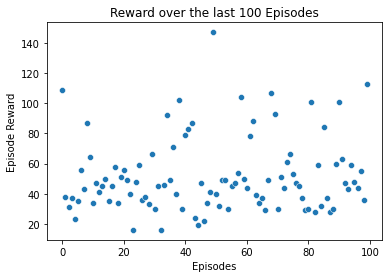

In [40]:
plot_rewards(results2)

With only the partial observations, i.e., without observing velocity, the RL agent does not learn a useful policy.
The reward does not increase notably over time and the resulting episode reward is rather small.


## Option 3: Use Sequence of Last Observations

Even if the velocity of cart and pole are not explicitly available in this example,
it can be derived by the RL agent by looking at a *sequence* of previous observations.
If the cart is always at the same position, its velocity is likely close to zero.
If its position varies greatly, it likely has high velocity.

Hence, one useful approach is to simply stack the last $n$ observations and providing this sequence as input to the RL agent.


### Option 3a: Use Raw Sequence as Input

Here, I consider the same default feed-forward neural network with PPO, just providing the stacked, partial observations as input.

#### Stacking Observations Using Gym's `FrameStack` Wrapper

To stack the last $n$ observations, I use Gym's `FrameStack` wrapper. As an example, I choose $n=4$.

In [11]:
from gym.wrappers import FrameStack

NUM_FRAMES = 4

# stateless CartPole --> only 2 observations: position of cart & angle of pole (not: velocity of cart or pole)
env = StatelessCartPole()
print(f"Shape of observation space (stateless CartPole): {env.observation_space.shape}")

# stack last n observations into sequence --> n x 2
env_stacked = FrameStack(env, NUM_FRAMES)
print(f"Shape of observation space (stacked stateless CartPole): {env_stacked.observation_space.shape}")

# register env for RLlib
registry.register_env("StackedStatelessCartPole", lambda _: FrameStack(StatelessCartPole(), NUM_FRAMES))

Shape of observation space (stateless CartPole): (2,)
Shape of observation space (stacked stateless CartPole): (4, 2)


In [12]:
#collapse-output

# use PPO with vanilla MLP
config3a = ppo.DEFAULT_CONFIG.copy()
config3a["env"] = "StackedStatelessCartPole"
# train; this takes a while
results3a = ray.tune.run("PPO", config=config3a, stop=stop)
print("Option 3a with FrameStack: Training finished successfully")

== Status ==
Current time: 2021-11-29 18:20:59 (running for 00:00:00.23)
Memory usage on this node: 9.0/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+------------------------------------------+----------+-------+
| Trial name                               | status   | loc   |
|------------------------------------------+----------+-------|
| PPO_StackedStatelessCartPole_b85a6_00000 | PENDING  |       |
+------------------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 18:21:04 (running for 00:00:05.23)
Memory usage on this node: 9.1/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+------------------------------------------+----------+-------+
| Trial name                               | status   | loc   |
|------------------------------------------+----------+-------|
| PPO_StackedStatelessCartPole_b85a6_00000 | PENDING  |       |
+------------------------------------------+----------+-------+




(pid=18488) 2021-11-29 18:21:17,962	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=18488) 2021-11-29 18:21:17,963	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=18488) 2021-11-29 18:21:17,963	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=15384) c:\users\stefan\git-repos\private\blog\venv\lib\site-packag

== Status ==
Current time: 2021-11-29 18:21:41 (running for 00:00:42.45)
Memory usage on this node: 10.4/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-----------------+
| Trial name                               | status   | loc             |
|------------------------------------------+----------+-----------------|
| PPO_StackedStatelessCartPole_b85a6_00000 | RUNNING  | 127.0.0.1:18488 |
+------------------------------------------+----------+-----------------+




(pid=18488) 2021-11-29 18:21:41,850	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=18488) 2021-11-29 18:21:41,850	INFO trainable.py:110 -- Trainable.setup took 23.904 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=18488) 2021-11-29 18:21:41,852	WARNING util.py:57 -- Install gputil for GPU system monitoring.


== Status ==
Current time: 2021-11-29 18:21:43 (running for 00:00:43.77)
Memory usage on this node: 10.4/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-----------------+
| Trial name                               | status   | loc             |
|------------------------------------------+----------+-----------------|
| PPO_StackedStatelessCartPole_b85a6_00000 | RUNNING  | 127.0.0.1:18488 |
+------------------------------------------+----------+-----------------+


== Status ==
Current time: 2021-11-29 18:21:48 (running for 00:00:48.84)
Memory usage on this node: 10.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-------

(pid=18488) 2021-11-29 18:21:50,403	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 18:21:53 (running for 00:00:54.04)
Memory usage on this node: 10.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+------------------------------------------+----------+-----------------+
| Trial name                               | status   | loc             |
|------------------------------------------+----------+-----------------|
| PPO_StackedStatelessCartPole_b85a6_00000 | RUNNING  | 127.0.0.1:18488 |
+------------------------------------------+----------+-----------------+


Result for PPO_StackedStatelessCartPole_b85a6_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-29_18-21-56
  done: false
  episode_len_mean: 23.60355029585799
  episode_media: {}
  episode_reward_max: 88.0
  episode_reward_mean: 23.60355029585799
  episode_reward_min: 8.0
  episodes_this_iter

(pid=18488) [2021-11-29 18:23:26,907 E 18488 22476] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=15384) [2021-11-29 18:23:26,906 E 15384 11108] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=15384) Windows fatal exception: access violation
(pid=15384) 
(pid=14576) [2021-11-29 18:23:26,903 E 14576 5636] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=14576) Windows fatal exception: access violation
(pid=14576) 
(pid=18488) Windows fatal exception: access violation
(pid=18488) 
2021-11-29 18:23:27,018	INFO tune.py:630 -- Total run time: 147.68 seconds (146.73 seconds for the tuning loop).


Option 3a with FrameStack: Training finished successfully


In [13]:
# check results
results3a.default_metric = "episode_reward_mean"
results3a.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3a.best_result["episode_reward_mean"]

185.29

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


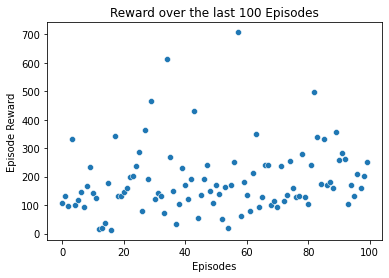

In [14]:
plot_rewards(results3a)

Simply by stacking the last $n$ observations, the RL agent learns a useful policy again -
even though each observation is still partial, i.e., missing the cart and pole velocity.


#### Stacking Observations Using RLlib's Trajectory API

Above, I used Gym's `FrameStack` wrapper to stack the last $n$ observations inside the environment.
Alternatively, the stacking can be implemented on the model side, e.g., using RLlib's trajectory API,
which reduces space complexity for storing the stacked observations but should lead to similar results.

In [15]:
#collapse-output

from ray.rllib.examples.models.trajectory_view_utilizing_models import FrameStackingCartPoleModel
from ray.rllib.models.catalog import ModelCatalog

ModelCatalog.register_custom_model("stacking_model", FrameStackingCartPoleModel)

config3a2 = ppo.DEFAULT_CONFIG.copy()
config3a2["env"] = "StatelessCartPole"
config3a2["model"] = {
    "custom_model": "stacking_model",
    "custom_model_config": {
        "num_frames": NUM_FRAMES,
    }
}

results3a2 = ray.tune.run("PPO", config=config3a2, stop=stop)
print("Option 3a2 with Trajectory API: Training finished successfully")

== Status ==
Current time: 2021-11-29 18:23:27 (running for 00:00:00.16)
Memory usage on this node: 9.6/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_10a86_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 18:23:32 (running for 00:00:05.16)
Memory usage on this node: 9.7/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_10a86_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=3524) 2021-11-29 18:23:42,046	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=3524) 2021-11-29 18:23:42,046	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=3524) 2021-11-29 18:23:42,046	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=23440) 2021-11-29 18:23:54,846	WARNING deprecation.py:38 -- Deprecati

== Status ==
Current time: 2021-11-29 18:23:59 (running for 00:00:31.72)
Memory usage on this node: 10.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_10a86_00000 | RUNNING  | 127.0.0.1:3524 |
+-----------------------------------+----------+----------------+




(pid=3524) 2021-11-29 18:23:59,330	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=3524) 2021-11-29 18:23:59,330	INFO trainable.py:110 -- Trainable.setup took 17.296 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=3524) 2021-11-29 18:23:59,330	WARNING util.py:57 -- Install gputil for GPU system monitoring.


== Status ==
Current time: 2021-11-29 18:24:00 (running for 00:00:32.74)
Memory usage on this node: 10.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_10a86_00000 | RUNNING  | 127.0.0.1:3524 |
+-----------------------------------+----------+----------------+




(pid=3524) 2021-11-29 18:24:03,613	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 18:24:06 (running for 00:00:38.79)
Memory usage on this node: 10.5/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_10a86_00000 | RUNNING  | 127.0.0.1:3524 |
+-----------------------------------+----------+----------------+


Result for PPO_StatelessCartPole_10a86_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-29_18-24-06
  done: false
  episode_len_mean: 19.265700483091788
  episode_media: {}
  episode_reward_max: 47.0
  episode_reward_mean: 19.265700483091788
  episode_reward_min: 8.0
  episodes_this_iter: 207
  episodes_total: 207
  experiment_id: 

(pid=3524) [2021-11-29 18:25:15,326 E 3524 10736] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=23440) [2021-11-29 18:25:15,333 E 23440 3596] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=8864) [2021-11-29 18:25:15,330 E 8864 8836] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
2021-11-29 18:25:15,446	INFO tune.py:630 -- Total run time: 107.86 seconds (107.47 seconds for the tuning loop).


Option 3a2 with Trajectory API: Training finished successfully


(pid=3524) Windows fatal exception: access violation
(pid=3524) 
(pid=23440) Windows fatal exception: access violation
(pid=23440) 
(pid=8864) Windows fatal exception: access violation
(pid=8864) 


In [16]:
# check results
results3a2.default_metric = "episode_reward_mean"
results3a2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3a2.best_result["episode_reward_mean"]

75.68

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


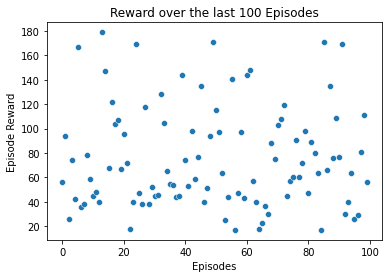

In [17]:
plot_rewards(results3a2)

### Option 3b: Use an LSTM for Processing the Sequence

Instead of stacking the last $n$ observations and providing this sequence as input to a regular feed-forward neural network,
a recurrent neural network (RNN) can be used, keeping track of a learned *state* that is passed onwards from observation to observation.

Long short-term memory (LSTM) networks are a variant of RNNs that are good at keeping state for longer durations.
To use an LSTM with RLlib, simply set the corresponding flag in the model config:

In [ ]:
#collapse-output

config3b = ppo.DEFAULT_CONFIG.copy()
config3b["env"] = "StatelessCartPole"
config3b["model"] = {
    "use_lstm": True,
    # "max_seq_len": 10,
}

results3b = ray.tune.run("PPO", config=config3b, stop=stop)
print("Option 3b: Training finished successfully")

== Status ==
Current time: 2021-11-29 18:28:37 (running for 00:00:00.17)
Memory usage on this node: 9.3/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_c9203_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


== Status ==
Current time: 2021-11-29 18:28:42 (running for 00:00:05.17)
Memory usage on this node: 9.4/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 PENDING)
+-----------------------------------+----------+-------+
| Trial name                        | status   | loc   |
|-----------------------------------+----------+-------|
| PPO_StatelessCartPole_c9203_00000 | PENDING  |       |
+-----------------------------------+----------+-------+




(pid=8716) 2021-11-29 18:28:53,746	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=8716) 2021-11-29 18:28:53,746	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=8716) 2021-11-29 18:28:53,746	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=2820) 2021-11-29 18:29:06,789	WARNING deprecation.py:38 -- Deprecatio

== Status ==
Current time: 2021-11-29 18:29:14 (running for 00:00:37.87)
Memory usage on this node: 10.1/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_c9203_00000 | RUNNING  | 127.0.0.1:8716 |
+-----------------------------------+----------+----------------+




(pid=8716) 2021-11-29 18:29:14,881	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=8716) 2021-11-29 18:29:14,881	INFO trainable.py:110 -- Trainable.setup took 21.135 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=8716) 2021-11-29 18:29:14,896	WARNING util.py:57 -- Install gputil for GPU system monitoring.


== Status ==
Current time: 2021-11-29 18:29:16 (running for 00:00:38.92)
Memory usage on this node: 10.1/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_c9203_00000 | RUNNING  | 127.0.0.1:8716 |
+-----------------------------------+----------+----------------+


== Status ==
Current time: 2021-11-29 18:29:22 (running for 00:00:45.04)
Memory usage on this node: 10.0/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+

(pid=8716) 2021-11-29 18:29:23,213	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


== Status ==
Current time: 2021-11-29 18:29:27 (running for 00:00:50.17)
Memory usage on this node: 10.1/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+----------------+
| Trial name                        | status   | loc            |
|-----------------------------------+----------+----------------|
| PPO_StatelessCartPole_c9203_00000 | RUNNING  | 127.0.0.1:8716 |
+-----------------------------------+----------+----------------+


== Status ==
Current time: 2021-11-29 18:29:32 (running for 00:00:55.28)
Memory usage on this node: 10.1/11.9 GiB
Using FIFO scheduling algorithm.
Resources requested: 3.0/3 CPUs, 0/0 GPUs, 0.0/1.7 GiB heap, 0.0/0.85 GiB objects
Result logdir: C:\Users\Stefan\ray_results\PPO
Number of trials: 1/1 (1 RUNNING)
+-----------------------------------+----------+

In [ ]:
# check results
results3b.default_metric = "episode_reward_mean"
results3b.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3b.best_result["episode_reward_mean"]

In [ ]:
plot_rewards(results3b)

#### LSTM with Stacked Observations

Using the `StackedStatelessCartPole` from above.

In [ ]:
#collapse-output

config3b2 = ppo.DEFAULT_CONFIG.copy()
config3b2["env"] = "StackedStatelessCartPole"
config3b2["model"] = {
    "use_lstm": True,
}

results3b2 = ray.tune.run("PPO", config=config3b2, stop=stop)
print("Option 3b2: Training finished successfully")

In [ ]:
# check results
results3b2.default_metric = "episode_reward_mean"
results3b2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3b2.best_result["episode_reward_mean"]

In [ ]:
plot_rewards(results3b2)

### Option 3c: Use Attention for Processing the Sequence

Self-attention is a recent and popular alternative to RNNs for processing sequence data.
Currently, the transformer architecture using self-attention is state of the art for natural language processing (NLP) tasks.

A similar, yet slightly modified architecture using attention is also useful for RL (see [related paper](https://arxiv.org/abs/1910.06764)).
Again, enabling attention in RLlib simply requires setting the corresponding flag in the model config:

In [ ]:
#collapse-output

config3c = ppo.DEFAULT_CONFIG.copy()
config3c["env"] = "StatelessCartPole"
config3c["model"] = {
    # Attention net wrapping (for tf) can already use the native keras
    # model versions. For torch, this will have no effect.
    "_use_default_native_models": True,
    "use_attention": True,
    # "max_seq_len": 10,
    # "attention_num_transformer_units": 1,
    # "attention_dim": 32,
    # "attention_memory_inference": 10,
    # "attention_memory_training": 10,
    # "attention_num_heads": 1,
    # "attention_head_dim": 32,
    # "attention_position_wise_mlp_dim": 32,
}

results3c = ray.tune.run("PPO", config=config3c, stop=stop)
print("Option 3c: Training finished successfully")

In [ ]:
# check results
results3c.default_metric = "episode_reward_mean"
results3c.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3c.best_result["episode_reward_mean"]

In [ ]:
plot_rewards(results3c)

#### Attention with Stacked Observations

In [ ]:
#collapse-output

config3c2 = ppo.DEFAULT_CONFIG.copy()
config3c2["env"] = "StackedStatelessCartPole"
config3c2["model"] = {
    "_use_default_native_models": True,
    "use_attention": True,
}

results3c2 = ray.tune.run("PPO", config=config3c2, stop=stop)
print("Option 3b2: Training finished successfully")

In [ ]:
# check results
results3c2.default_metric = "episode_reward_mean"
results3c2.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results3c2.best_result["episode_reward_mean"]

In [ ]:
plot_rewards(results3c2)